In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

#Running the script with parameter definitions and functions:
%run populations_functions.py

K = 1; 0.5*dg/dt = 1250.0
D = 50.0; 0.5*dg**2/dt = 500.00000000000006


In [2]:
#Start with some sugar levels, which are uniformly distributed:
sugars_info = np.linspace(60,430,num=16)
p_sugars = np.ones_like(sugars_info)
p_sugars = p_sugars/np.sum(p_sugars)

#Now, some values of the expression noise alpha:
# alphas = np.logspace(np.log10(0.2),np.log10(5),2)
alphas = np.logspace(np.log10(0.5),np.log10(5),5)
deltas = np.logspace(-1,np.log10(25),num=6)

#Define the quantities we need. First, colony fitness:
col_fit_unreg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_unsel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_unreg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))
col_fit_reg_sel = np.zeros((len(alphas),len(deltas),len(sugars_info)))

#Fitness across all sugars:
tot_fit_unreg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_unsel = np.zeros((len(alphas),len(deltas)))
tot_fit_unreg_sel = np.zeros((len(alphas),len(deltas)))
tot_fit_reg_sel = np.zeros((len(alphas),len(deltas)))

# #To compute mutual information, we use the formula I(g;s) = H(g) - H(g|s). For H(g), we need the marginal...
# #...distributions for all four cases:
# marg_unreg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
# marg_reg_unsel = np.zeros((len(alphas),len(deltas),len(g)))
# marg_unreg_sel = np.zeros((len(alphas),len(deltas),len(g)))
# marg_reg_sel = np.zeros((len(alphas),len(deltas),len(g)))

# #Then we need the conditional entropies H(g|s). We'll calculate these inside the sugar loop:
# condEnt_unreg_unsel = np.zeros((len(alphas),len(deltas)))
# condEnt_reg_unsel = np.zeros((len(alphas),len(deltas)))
# condEnt_unreg_sel = np.zeros((len(alphas),len(deltas)))
# condEnt_reg_sel = np.zeros((len(alphas),len(deltas)))

# #The marginal entropy H(g):
# ent_unreg_unsel = np.zeros((len(alphas),len(deltas)))
# ent_reg_unsel = np.zeros((len(alphas),len(deltas)))
# ent_unreg_sel = np.zeros((len(alphas),len(deltas)))
# ent_reg_sel = np.zeros((len(alphas),len(deltas)))

# #Finally, MI as a function of noise:
# MI_unreg_unsel = np.zeros((len(alphas),len(deltas)))
# MI_reg_unsel = np.zeros((len(alphas),len(deltas)))
# MI_unreg_sel = np.zeros((len(alphas),len(deltas)))
# MI_reg_sel = np.zeros((len(alphas),len(deltas)))

In [3]:
for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    for delta_idx in range(len(deltas)):
        delta = deltas[delta_idx]
        print(f"alpha={alpha}; delta={delta}\n")
        #Defining p0_unreg:
        g_peak = 0.5*(g_min+g_max)
#         p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
        p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1)).astype('float64')

        #Now looping over sugars:
        for sug_idx in range(len(sugars_info)):
            #Sugar, fitness function for this sugar and the optimal g:
            sug = sugars_info[sug_idx]
            fit = fitness(g,sug,delta)
            g_reg = g[np.argmax(fit)]
            #The fitness range:
            fit_range = np.max(fitness(g,sug,delta))-np.min(fitness(g,sug,delta))
            #Defining p0_reg
#             p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
            p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1)).astype('float64')
            p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

            #Calculating the normalized colony fitness (dividing by max possible fitness, f(g_reg,s)) already for p0_unreg and p0_reg:
            col_fit_unreg_unsel[alpha_idx][delta_idx][sug_idx] = mean_wrt_P(fit,p0_unreg,g)
            col_fit_reg_unsel[alpha_idx][delta_idx][sug_idx] = mean_wrt_P(fit,p0_reg,g)
#             #Calculating the marginals for these above two cases:
#             marg_unreg_unsel[alpha_idx][delta_idx] = marg_unreg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_unreg
#             marg_reg_unsel[alpha_idx][delta_idx] = marg_reg_unsel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p0_reg
#             #Now conditional entropies:
#             dummy = np.clip(p0_unreg,0,None)
#             dummy = dummy[dummy.nonzero()]
#             condEnt_unreg_unsel[alpha_idx][delta_idx] = condEnt_unreg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
#             dummy = np.clip(p0_reg,0,None)
#             dummy = dummy[dummy.nonzero()]
#             condEnt_reg_unsel[alpha_idx][delta_idx] = condEnt_reg_unsel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

            #Now running the solver, i.e. letting selection take its course:
            p_unreg,p_reg = selection(p0_unreg,p0_reg,sug,alpha,delta)

            #Colony fitness for p_unreg and p_reg:
            col_fit_unreg_sel[alpha_idx][delta_idx][sug_idx] = mean_wrt_P(fit,p_unreg,g)
            col_fit_reg_sel[alpha_idx][delta_idx][sug_idx] = mean_wrt_P(fit,p_reg,g)
#             #Now their marginals:
#             marg_unreg_sel[alpha_idx][delta_idx] = marg_unreg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_unreg
#             marg_reg_sel[alpha_idx][delta_idx] = marg_reg_sel[alpha_idx][delta_idx] + p_sugars[sug_idx]*p_reg        
#             #The conditional entropy for p_unreg and p_reg, given by - P(s) sum_g P_reg(g|s) log2 P_reg(g|s):
#             dummy = np.clip(p_unreg,0,None)
#             dummy = dummy[dummy.nonzero()]
#             condEnt_unreg_sel[alpha_idx][delta_idx] = condEnt_unreg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
#             dummy = np.clip(p_reg,0,None)
#             dummy = dummy[dummy.nonzero()]
#             condEnt_reg_sel[alpha_idx][delta_idx] = condEnt_reg_sel[alpha_idx][delta_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

        #Ending the sugar loop. First we compute the total fitness across all sugars:
        tot_fit_unreg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_unsel[alpha_idx][delta_idx] = np.sum(col_fit_reg_unsel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_unreg_sel[alpha_idx][delta_idx] = np.sum(col_fit_unreg_sel[alpha_idx][delta_idx]*p_sugars)
        tot_fit_reg_sel[alpha_idx][delta_idx] = np.sum(col_fit_reg_sel[alpha_idx][delta_idx]*p_sugars)

#         #Now calculating the marginal entropies and information:
#         dummy = np.clip(marg_unreg_unsel[alpha_idx][delta_idx],0,None)
#         dummy = dummy[dummy.nonzero()]
#         ent_unreg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
#         MI_unreg_unsel[alpha_idx][delta_idx] = ent_unreg_unsel[alpha_idx][delta_idx] - condEnt_unreg_unsel[alpha_idx][delta_idx]

#         dummy = np.clip(marg_reg_unsel[alpha_idx][delta_idx],0,None)
#         dummy = dummy[dummy.nonzero()]
#         ent_reg_unsel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
#         MI_reg_unsel[alpha_idx][delta_idx] = ent_reg_unsel[alpha_idx][delta_idx] - condEnt_reg_unsel[alpha_idx][delta_idx]

#         dummy = np.clip(marg_unreg_sel[alpha_idx][delta_idx],0,None)
#         dummy = dummy[dummy.nonzero()]
#         ent_unreg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
#         MI_unreg_sel[alpha_idx][delta_idx] = ent_unreg_sel[alpha_idx][delta_idx] - condEnt_unreg_sel[alpha_idx][delta_idx]

#         dummy = np.clip(marg_reg_sel[alpha_idx][delta_idx],0,None)
#         dummy = dummy[dummy.nonzero()]
#         ent_reg_sel[alpha_idx][delta_idx] = -np.sum(dummy*np.log2(dummy))
#         MI_reg_sel[alpha_idx][delta_idx] = ent_reg_sel[alpha_idx][delta_idx] - condEnt_reg_sel[alpha_idx][delta_idx]
        
#Writing to files:
np.savetxt("4b_fit_unreg_unsel.txt",tot_fit_unreg_unsel.flatten())
np.savetxt("4b_fit_reg_unsel.txt",tot_fit_reg_unsel.flatten())
np.savetxt("4b_fit_unreg_sel.txt",tot_fit_unreg_sel.flatten())
np.savetxt("4b_fit_reg_sel.txt",tot_fit_reg_sel.flatten())

# np.savetxt("4b_MI_unreg_unsel.txt",MI_unreg_unsel.flatten())
# np.savetxt("4b_MI_reg_unsel.txt",MI_reg_unsel.flatten())
# np.savetxt("4b_MI_unreg_sel.txt",MI_unreg_sel.flatten())
# np.savetxt("4b_MI_reg_sel.txt",MI_reg_sel.flatten())

alpha=0.5; delta=0.1

alpha=0.5; delta=0.30170881682725814

alpha=0.5; delta=0.9102821015130401

alpha=0.5; delta=2.746401358265295

alpha=0.5; delta=8.286135043349967

alpha=0.5; delta=25.000000000000007

alpha=0.8891397050194614; delta=0.1

alpha=0.8891397050194614; delta=0.30170881682725814

alpha=0.8891397050194614; delta=0.9102821015130401

alpha=0.8891397050194614; delta=2.746401358265295

alpha=0.8891397050194614; delta=8.286135043349967

alpha=0.8891397050194614; delta=25.000000000000007

alpha=1.5811388300841898; delta=0.1

alpha=1.5811388300841898; delta=0.30170881682725814

alpha=1.5811388300841898; delta=0.9102821015130401

alpha=1.5811388300841898; delta=2.746401358265295

alpha=1.5811388300841898; delta=8.286135043349967

alpha=1.5811388300841898; delta=25.000000000000007

alpha=2.8117066259517456; delta=0.1

alpha=2.8117066259517456; delta=0.30170881682725814

alpha=2.8117066259517456; delta=0.9102821015130401

alpha=2.8117066259517456; delta=2.746401358265295

alpha=2.8

In [4]:
#Reading from files:
tot_fit_unreg_unsel = np.loadtxt("4b_fit_unreg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_unsel = np.loadtxt("4b_fit_reg_unsel.txt").reshape(len(alphas),len(deltas))
tot_fit_unreg_sel = np.loadtxt("4b_fit_unreg_sel.txt").reshape(len(alphas),len(deltas))
tot_fit_reg_sel = np.loadtxt("4b_fit_reg_sel.txt").reshape(len(alphas),len(deltas))

# MI_unreg_unsel = np.loadtxt("4b_MI_unreg_unsel.txt").reshape(len(alphas),len(deltas))
# MI_reg_unsel = np.loadtxt("4b_MI_reg_unsel.txt").reshape(len(alphas),len(deltas))
# MI_unreg_sel = np.loadtxt("4b_MI_unreg_sel.txt").reshape(len(alphas),len(deltas))
# MI_reg_sel = np.loadtxt("4b_MI_reg_sel.txt").reshape(len(alphas),len(deltas))

In [5]:
tot_fit_unreg_unsel[:,0]

array([0.97827735, 0.9748593 , 0.96872078, 0.95759713, 0.93661988])

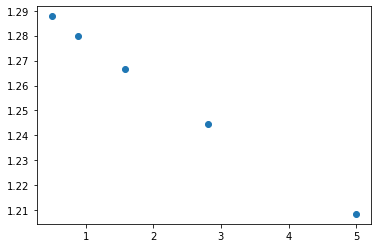

In [6]:
plt.scatter(alphas,tot_fit_reg_unsel[:,0],label='with reg.')


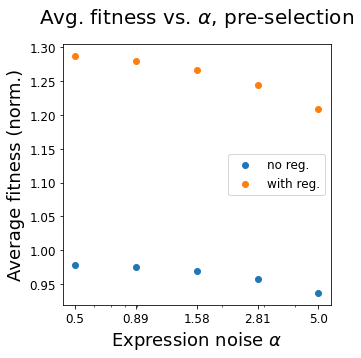

In [7]:
fig,ax = plt.subplots(1,1,figsize=[4.8,4.8])
ax.set_xscale('log')
# ax.set_ylim([0.05,2.5])
# ax.set_aspect('equal',adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.scatter(alphas,tot_fit_unreg_unsel[:,0],label='no reg.')
ax.scatter(alphas,tot_fit_reg_unsel[:,0],label='with reg.')
ax.set_xticks(alphas)
ax.set_xticklabels(np.around(alphas,2))
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Average fitness (norm.)",fontsize=18)
ax.legend(loc='best',fontsize=12)
ax.text(0.5,1.1,fr"Avg. fitness vs. $\alpha$, pre-selection",va='center',ha='center',transform=ax.transAxes,fontsize=20)
fig.savefig(f"4b_fit_unsel_vs_alpha.pdf",format="pdf",dpi=2000,bbox_inches="tight",pad_inches=0.05)

In [11]:
np.log(tot_fit_unreg_sel)

array([[-1.40237600e-02,  1.10574739e+00,  2.25190235e+00,
         3.43862314e+00,  4.61920613e+00,  5.75979651e+00],
       [-1.15260757e-02,  1.11910698e+00,  2.28689866e+00,
         3.47924918e+00,  4.63855339e+00,  5.76634308e+00],
       [-7.58824678e-03,  1.13954583e+00,  2.32575821e+00,
         3.50549492e+00,  4.64785606e+00,  5.76885688e+00],
       [-2.27402297e-03,  1.16688226e+00,  2.35495887e+00,
         3.51730257e+00,  4.65061519e+00,  5.76876214e+00],
       [ 1.76703670e-03,  1.19121664e+00,  2.36559984e+00,
         3.51880980e+00,  4.64903421e+00,  5.76679994e+00]])

Looks like there is some nonzero effect of $\alpha$ on the total fitness, but it is quite small and overshadowed by the increase because of stronger selection $\delta$.


In [6]:
# #Excess fitness given by regulation with precise sensing:
# phase_diag = (tot_fit_reg_unsel-tot_fit_unreg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
# fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
# pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
# cbar = plt.colorbar(pic)
# cbar.set_label(r"Excess fitness (normalized)",fontsize=16)
# plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
# plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
# ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
# ax.set_title(f"Fitness benefit of reg.",fontsize=20)
# # fig.savefig("2a_fitness_phase_diagram.svg", format="svg")
# fig.savefig("2a_fitness_phase_diagram.eps", format="eps")

In [7]:
# # Excess information given by regulation with precise sensing:
# phase_diag = (MI_reg_unsel-MI_unreg_sel).T
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
# fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
# pic=ax.imshow(phase_diag,vmin=-cbar_lim,vmax=cbar_lim,cmap='seismic',aspect='equal',origin='lower')
# cbar = plt.colorbar(pic)
# cbar.set_label(r"Excess information (bits)",fontsize=16)
# plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=1))
# plt.yticks(ticks=range(6),labels=np.around(np.logspace(-1,np.log10(25),num=6),decimals=1))
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
# ax.set_ylabel(r"Growth advantage $\delta$",fontsize=18)
# ax.set_title(f"Information benefit of reg.",fontsize=20)
# # fig.savefig("2a_MI_phase_diagram.svg", format="svg")
# fig.savefig("2a_MI_phase_diagram.eps", format="eps")

In [89]:
# fig,ax = plt.subplots(7,1,figsize=[2.625,10.5],sharex=True,sharey=True)

# ax[0].scatter(alphas,tot_fit_unreg_unsel[:,0])
# ax[0].scatter(alphas,tot_fit_reg_unsel[:,0])
# ax[0].set_xscale('log')
# ax[0].set_xticks(alphas)
# ax[0].set_xticklabels(np.around(alphas,2))
# ax[0].set_ylim([0.75,1.05])

# ax[1].scatter(alphas,tot_fit_unreg_sel[:,0])
# ax[1].scatter(alphas,tot_fit_reg_sel[:,0])

# ax[2].scatter(alphas,tot_fit_unreg_sel[:,1])
# ax[2].scatter(alphas,tot_fit_reg_sel[:,1])

# ax[3].scatter(alphas,tot_fit_unreg_sel[:,2])
# ax[3].scatter(alphas,tot_fit_reg_sel[:,2])

# ax[4].scatter(alphas,tot_fit_unreg_sel[:,3])
# ax[4].scatter(alphas,tot_fit_reg_sel[:,3])

# ax[5].scatter(alphas,tot_fit_unreg_sel[:,4])
# ax[5].scatter(alphas,tot_fit_reg_sel[:,4])

# ax[6].scatter(alphas,tot_fit_unreg_sel[:,5])
# ax[6].scatter(alphas,tot_fit_reg_sel[:,5])

# plt.subplots_adjust(hspace=0)

Text(0.5, 1.0, 'Average fitness (no reg.)')

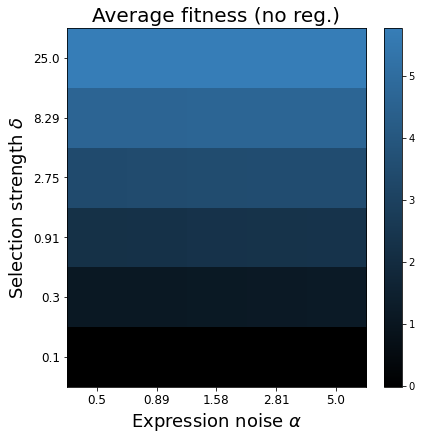

In [8]:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

N = 256
no_reg = np.ones((N, 4))
no_reg[:, 0] = np.linspace(0, 55/256, N) # R = 55
no_reg[:, 1] = np.linspace(0, 126/256, N) # G = 126
no_reg[:, 2] = np.linspace(0, 184/256, N)  # B = 184
no_reg_cmp = ListedColormap(no_reg)

fig,ax = plt.subplots(1,1,figsize=[6,6],constrained_layout='true')
pic=ax.imshow(np.log(tot_fit_unreg_sel.T),cmap=no_reg_cmp,origin='lower')
cbar = plt.colorbar(pic,shrink=1.0)
ax.set_xticks(ticks=range(5),labels=np.around(alphas,decimals=2))
ax.set_yticks(ticks=range(6),labels=np.around(deltas,decimals=2))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Expression noise $\alpha$',fontsize=18)
ax.set_ylabel(r'Selection strength $\delta$',fontsize=18)
ax.set_title(r'Average fitness (no reg.)',fontsize=20)
# fig.savefig(f"4b_fit_unreg_sel_vs_alpha&delta.pdf",format="pdf",dpi=1200,bbox_inches="tight",pad_inches=0.05)

Text(0.5, 1.0, 'Average fitness (with reg.)')

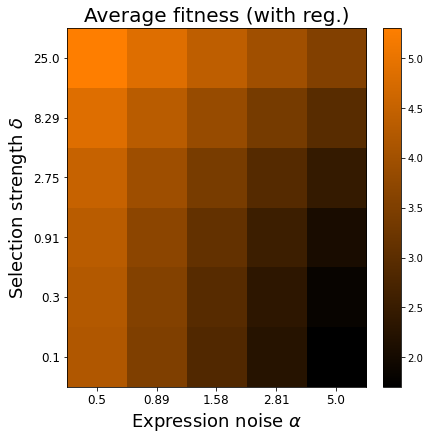

In [9]:
N = 256
with_reg = np.ones((N, 4))
with_reg[:, 0] = np.linspace(0, 255/256, N) # R = 255
with_reg[:, 1] = np.linspace(0, 127/256, N) # G = 127
with_reg[:, 2] = np.linspace(0, 0/256, N)  # B = 0
with_reg_cmp = ListedColormap(with_reg)

fig,ax = plt.subplots(1,1,figsize=[6,6],constrained_layout='true')
pic=ax.imshow(MI_reg_sel.T,cmap=with_reg_cmp,origin='lower')
cbar = plt.colorbar(pic,shrink=1)
ax.set_xticks(ticks=range(5),labels=np.around(alphas,decimals=2))
ax.set_yticks(ticks=range(6),labels=np.around(deltas,decimals=2))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Expression noise $\alpha$',fontsize=18)
ax.set_ylabel(r'Selection strength $\delta$',fontsize=18)
ax.set_title(r'Average fitness (with reg.)',fontsize=20)
# fig.savefig(f"4b_fit_reg_sel_vs_alpha&delta.pdf",format="pdf",dpi=1200,bbox_inches="tight",pad_inches=0.05)

In [41]:
np.max(MI_reg_sel)

5.368219060589221